In [1]:
# !pip install h5py
import h5py

# 破解h5

In [2]:
f = h5py.File("/home/nandahgy/yqc_model/1_MODFLOW/1.h5",'r')
list(f.keys())

['Arrays',
 'Drain',
 'Drain Return',
 'ET',
 'ETS',
 'File Type',
 'File Version',
 'General Head',
 'MFH5 Version',
 'MNW2',
 'Multi-Node Well',
 'Recharge',
 'River',
 'SUB',
 'Specified Head',
 'Stream',
 'Stream (SFR2)',
 'UZF',
 'Well']

In [3]:
print(f['Recharge']['07. Property'])
print(f['Recharge']['07. Property'][0][0][:])
print(f['Recharge']['07. Property'][0][93561][:])

<HDF5 dataset "07. Property": shape (1, 93562, 3), type "<f8">
[0. 0. 0.]
[0. 0. 0.]


In [4]:
NROW = 287
NCOL = 326
# for i in range(93562):
#   if f['Recharge']['07. Property'][0][i][0] != 0:
#     print(i//NCOL)

In [5]:
import numpy as np

In [6]:
NROW = 287
NCOL = 326
nums = [0]*93562

nums = list(f['Arrays']['ibound1'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
ibound1 = np.array(tmp)



nums = list(f['Arrays']['ibound2'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
ibound2 = np.array(tmp)


nums = list(f['Arrays']['ibound3'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
ibound3 = np.array(tmp)

In [7]:
nums = list(f['Arrays']['top1'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
top1 = np.array(tmp)

In [8]:
nums = list(f['Arrays']['bot1'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
bot1 = np.array(tmp)

nums = list(f['Arrays']['bot2'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
bot2 = np.array(tmp)

nums = list(f['Arrays']['bot3'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
bot3 = np.array(tmp)

In [9]:
bot3[100,100]

-32.0

In [10]:
nums1 = list(f['Arrays']['StartHead1'])
tmp = []
for i in range(NROW):
  tmp.append(nums1[i*NCOL:(1+i)*NCOL])
StartHead1 = np.array(tmp) 

nums = list(f['Arrays']['StartHead2'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
StartHead2 = np.array(tmp) 

nums = list(f['Arrays']['StartHead3'])
tmp = []
for i in range(NROW):
  tmp.append(nums[i*NCOL:(1+i)*NCOL])
  # print(nums[i*NCOL:(1+i)*NCOL])
StartHead3 = np.array(tmp) 

# 基于mf6的溶质运移模型(再试一遍)

https://zhuanlan.zhihu.com/p/532012679

In [11]:
# Filename
sim_ws = 'simulation3'
sim_name = 'model'          # 模拟总名称
gwfname = "gwf_" + sim_name # 渗流模型名称
gwtname = "gwt_" + sim_name # 溶质运移模型名称

In [12]:
# Units
length_units = "meters"   # 长度单位
time_units = "days"       # 时间单位

## 离散层数

In [13]:
# Discretization
import numpy as np
nper = 1                  # 稳定流，周期数为 1
nlay = 3                  # 层数
nrow = 287                 # 行数
ncol = 326                 # 列数
delr = 10.0               # 单位行长
delc = 10.0               # 单位列长
delz = 10.0               # 单位层高
Lx = delr * nrow
Ly = delc * ncol
top = 3.0                 # 顶部高程
botm = [-3.0,-17.0,-32.0]
# botm = [-delz * k for k in range(1, nlay + 1)]     # 底部高程（多层，为列表）
idomain = np.ones((nlay, nrow, ncol), dtype = int) # 参与模拟的区域，1 为参与
idomain[0,:,:] = ibound1
idomain[1,:,:] = ibound2
idomain[2,:,:] = ibound3

In [14]:
botm

[-3.0, -17.0, -32.0]

In [15]:
# 设置溶质运移模型专门参数:
# GWT
porosity = 0.2
al = 50.0                    # 纵向弥散系数
trpt = 0.3; ath1 = al * trpt # 横向弥散系数
trpv = 0.3; atv = al * trpv  # 垂直弥散系数

# 设置渗流模型专门参数:

# GWF
icelltype = 0
k11 = 0.5
k33 = k11

In [16]:
# 时间离散化参数:
# Temporal discretization
perlen = 100.0
nstp = 10
tsmult = 1.0
tdis_ds = []
tdis_ds.append((perlen, nstp, tsmult),)
print(tdis_ds)

# 求解器参数：
# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0

[(100.0, 10, 1.0)]


In [17]:
# 初始条件: # Initial conditions
# Starting concentrations 初始浓度
sconc = 0.0
# Starting Heads 初始水头
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0,:,:] = StartHead1
strt[1,:,:] = StartHead2
strt[2,:,:] = StartHead3

print(StartHead1[100,100])
print(StartHead2[100,100])
print(StartHead3[100,100])

3.0
-3.0
-17.0


## 井

In [18]:
# 边界条件: # Boundary conditions
# wel_spd 井
qwell = 0
cwell = 1000.0
#               (k, i, j),  flow,  conc
wel_spd = {0: [[(2, 100, 100), qwell, cwell]]}


In [19]:
# chd_spd 指定水头
chd_spd = []
cnt = 0
for k in np.arange(nlay): # 东西两侧分别指定
    # for i in np.arange(nrow):
    #     #               (l, r, c),          head, conc
    #     chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
    #     chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 100.0])

    for j in np.arange(ncol): # 南北两侧分别指定
        for i in np.arange(nrow):
            #         (l, r, c),    head, conc
            if idomain[k][i][j] == 1:
              chd_spd.append([(k, i, j), strt[k, i, j], 100.0])
              cnt += 1
              break
        for i in np.arange(nrow-1,-1,-1):
            #         (l, r, c),    head, conc
            if idomain[k][i][j] == 1:
              chd_spd.append([(k, i, j), strt[k, i, j], 100.0])
              cnt += 1
              break
chd_spd = {0: chd_spd}
cnt

1866

In [20]:
# chd_spd 指定水头
# chd_spd = []
# for k in np.arange(nlay): # 东西两侧分别指定
#     for i in np.arange(nrow):
#         #               (l, r, c),          head, conc
#         chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
#         chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
# chd_spd = {0: chd_spd}

# print(chd_spd)

## 建模并计算

In [21]:
import flopy
def build_model():
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name='/usr/local/lib/modflow/mf6'
    )

    # 时间离散化
    flopy.mf6.ModflowTdis(
        sim, nper=nper, perioddata=tdis_ds, time_units=time_units
    )

    # GWF
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwfname),
    )

    # 渗流模型求解参数
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwfname),
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # 离散化
    dis6 = flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwfname),
    )

    # 含水层特性
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=0.5,
        k22=1.0,
        k33=3.0,
        save_specific_discharge=True,
        filename="{}.npf".format(gwfname),
    )
    

    # 初始水头
    flopy.mf6.ModflowGwfic(
        gwf, strt=strt, filename="{}.ic".format(gwfname)
    )

    # 指定水头边界
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chd_spd),
        stress_period_data=chd_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename="{}.chd".format(gwfname),
    )

    # 井边界
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_spd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="WEL-1",
        filename="{}.wel".format(gwfname),
    )

    # 补给recharge
    flopy.mf6.ModflowGwfrcha(
        gwf,
        recharge=0.0001,
        filename="{}.rch".format(gwfname),
    )

    # 蒸发
    flopy.mf6.ModflowGwfevta(
        gwf,
        surface=2.0,
        rate=0.000103,
        depth=5.0,
        filename="{}.evt".format(gwfname),
    )

    # 输出控制
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord="{}.hds".format(gwfname),
        budget_filerecord="{}.bud".format(gwfname),
        headprintrecord=[
            ("COLUMNS", 100, "WIDTH", 150, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    # GWT
    gwt = flopy.mf6.ModflowGwt(
        sim,
        modelname=gwtname,
        save_flows=True,
        model_nam_file="{}.nam".format(gwtname),
    )

    # 溶质运移模型求解参数
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwtname),
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # 离散化
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename="{}.dis".format(gwtname),
    )

    # 初始浓度
    flopy.mf6.ModflowGwtic(
        gwt, strt=sconc, filename="{}.ic".format(gwtname)
    )

    # 对流
    flopy.mf6.ModflowGwtadv(
        gwt, scheme="UPSTREAM", filename="{}.adv".format(gwtname)
    )

    # 弥散
    flopy.mf6.ModflowGwtdsp(
        gwt,
        alh=al,
        ath1=ath1,
        atv=atv,
        filename="{}.dsp".format(gwtname),
    )

    # 化学反应 (等同于 MT3DMS 的 reaction)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename="{}.mst".format(gwtname),
    )

    # 源汇项
    sourcerecarray = [
        ("WEL-1", "AUX", "CONCENTRATION"),
        ("CHD-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(
        gwt, sources=sourcerecarray, filename="{}.ssm".format(gwtname)
    )

    # 输出控制
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord="{}.cbc".format(gwtname),
        concentration_filerecord="{}.ucn".format(gwtname),
        concentrationprintrecord=[
            ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
    )

    # GWF 和 GWT 之间的交换
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename="{}.gwfgwt".format(sim_name),
    )
    return sim, gwf, gwt, dis6

sim, gwf, gwt, dis6 = build_model()
sim.write_simulation(silent = True)

success, buff = sim.run_simulation(silent = True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

## 查看结果

In [22]:
# 运行完毕后，分别读取水头和浓度结果（我们使用 get_alldata 读取了全部时刻的结果）:

head = gwf.oc.output.head().get_alldata()
concentration = gwt.oc.output.concentration().get_alldata()

# 我们可以查看结果的维度:

print(head.shape)
print(concentration.shape)

# 10: 时间 - nstp 值。
# (8, 15, 21): 网格空间

(10, 3, 287, 326)
(10, 3, 287, 326)


In [23]:
# print(head[9,2])
print(concentration[9,1])

[[1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 ...
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]
 [1.e+30 1.e+30 1.e+30 ... 1.e+30 1.e+30 1.e+30]]


/usr/local/lib/python3.9/dist-packages/flopy/plot/map.py:243: UserWarning: No contour levels were found within the data range.
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


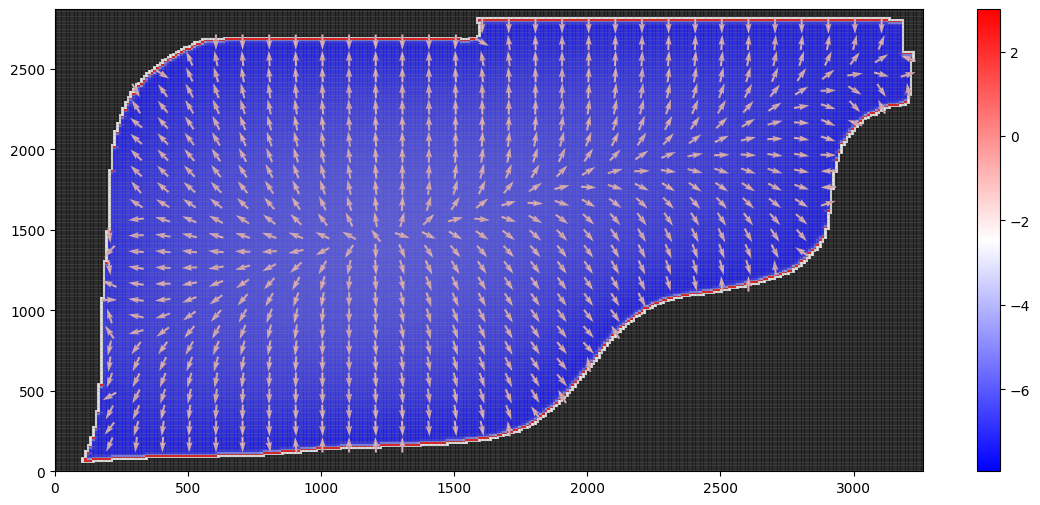

In [24]:
import matplotlib.pyplot as plt
def plot_results(model, result):
    fig = plt.figure(figsize = (14, 6))
    ax = fig.add_subplot(1, 1, 1)
    pmv = flopy.plot.PlotMapView(model = model, ax = ax, layer = 0)
    pmv.plot_grid(ax = ax, color = ".5", alpha = 0.2) # 绘制网格
    
    # 网格填充颜色
    plot_array = pmv.plot_array(head[9,0], masked_values = [1e30], cmap = 'bwr')
    plt.colorbar(plot_array)
    
    # 绘制等值线
    plot_contour_array = pmv.contour_array(result, masked_values = [1e30], cmap = "brg", linestyles="--")
    plt.clabel(plot_contour_array, fmt = r'%.2f') # 绘制等值线上文本标注
    # plt.colorbar(plot_contour_array)              # 等值线图例
    
    pmv.plot_bc(package = gwf.get_package("WEL-1"), color = 'green')
    pmv.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')
    
    # 绘制水流的方向 (粉红色箭头)
    spdis = gwf.oc.output.budget().get_data(text = 'DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    pmv.plot_vector(qx, qy, normalize = True, istep = 10, jstep = 10, color = "pink")
    
plot_results(model = gwf, result = concentration[9,0])

# MODPATH7 Model

In [25]:
# Define names for the MODPATH 7 simulations
mp_namea = sim_name + "a_mp"
mp_nameb = sim_name + "b_mp"

In [26]:
# create particles
# particle group 1
# plocs = []
# pids = []
# for idx in range(nrow):
#     plocs.append((0, idx, 2))
#     pids.append(idx)
# part0 = flopy.modpath.ParticleData(
#     plocs, drape=0, structured=True, particleids=pids
# )
# locs = [(0, 0, 0), (1, 0, 0), (2, 0, 0)]

In [27]:
pcoord = np.array(
    [
        [0.000, 0.125, 0.500],
        [0.000, 0.375, 0.500],
        [0.000, 0.625, 0.500],
        [0.000, 0.875, 0.500],
        [1.000, 0.125, 0.500],
        [1.000, 0.375, 0.500],
        [1.000, 0.625, 0.500],
        [1.000, 0.875, 0.500],
        [0.125, 0.000, 0.500],
        [0.375, 0.000, 0.500],
        [0.625, 0.000, 0.500],
        [0.875, 0.000, 0.500],
        [0.125, 1.000, 0.500],
        [0.375, 1.000, 0.500],
        [0.625, 1.000, 0.500],
        [0.875, 1.000, 0.500],
    ]
)

pcoord.shape[0]

16

In [28]:
nodew = (2, 100, 100)
plocs = [nodew for i in range(pcoord.shape[0])]
# create particle data
pa = flopy.modpath.ParticleData(
    plocs,
    structured=True,
    localx=pcoord[:, 0],
    localy=pcoord[:, 1],
    localz=pcoord[:, 2],
    drape=0,
)

# create backward particle group
fpth = mp_namea + ".sloc"
pga = flopy.modpath.ParticleGroup(
    particlegroupname="BACKWARD1", particledata=pa, filename=fpth
)

In [29]:
model_ws=sim_ws
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=mp_namea, flowmodel=gwf, exe_name="/usr/local/lib/modflow/mp7", model_ws=model_ws
)
flopy.modpath.Modpath7Bas(mp, porosity=0.2)
flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=pga,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mp7

MODPATH Version 7.2.001   
Program compiled Mar 08 2022 20:16:00 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        16 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

加载pathline和timeseries数据

In [30]:
fpth = os.path.join(model_ws, mp_namea + ".mppth")
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()
fpth = os.path.join(model_ws, mp_namea + ".timeseries")
ts = flopy.utils.TimeseriesFile(fpth)
ts0 = ts.get_alldata()

## 画出pathline和timeseries数据

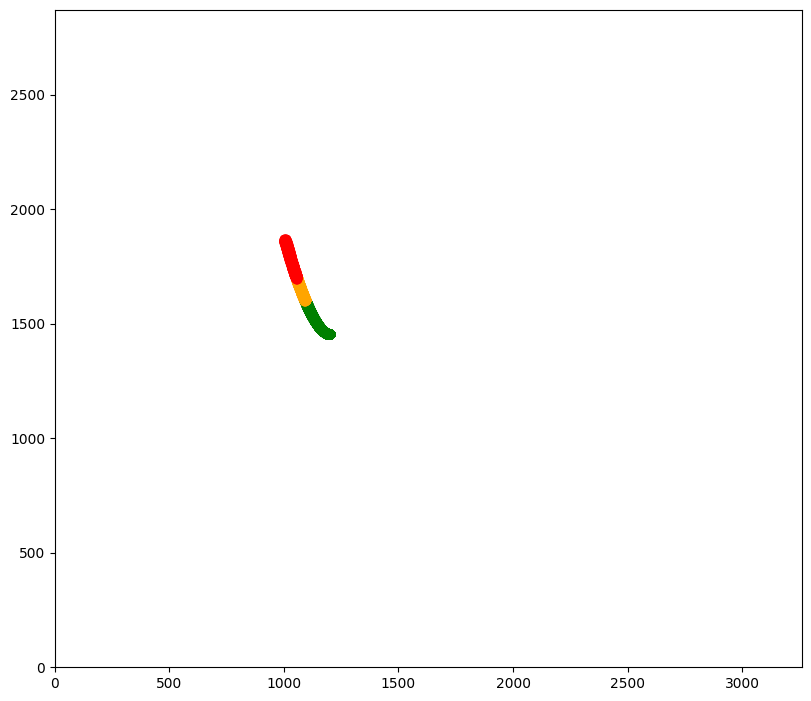

In [31]:
import matplotlib as mpl
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)
# pmv = flopy.plot.PlotMapView(model = gwf, ax = ax, layer = 0)
# mm.plot_grid(ax = ax, color = ".5", alpha = 0.2) # 绘制网格
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
v = mm.plot_array(gwf.modelgrid.idomain, cmap=cmap, edgecolor="white")
mm.plot_pathline(p0, layer="all", color="blue", lw=0.75)
colors = ["green", "orange", "red"]
for k in range(nlay):
    mm.plot_timeseries(ts0, layer=k, marker="o", lw=0, color=colors[k]);

/usr/local/lib/python3.9/dist-packages/flopy/plot/map.py:243: UserWarning: No contour levels were found within the data range.
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


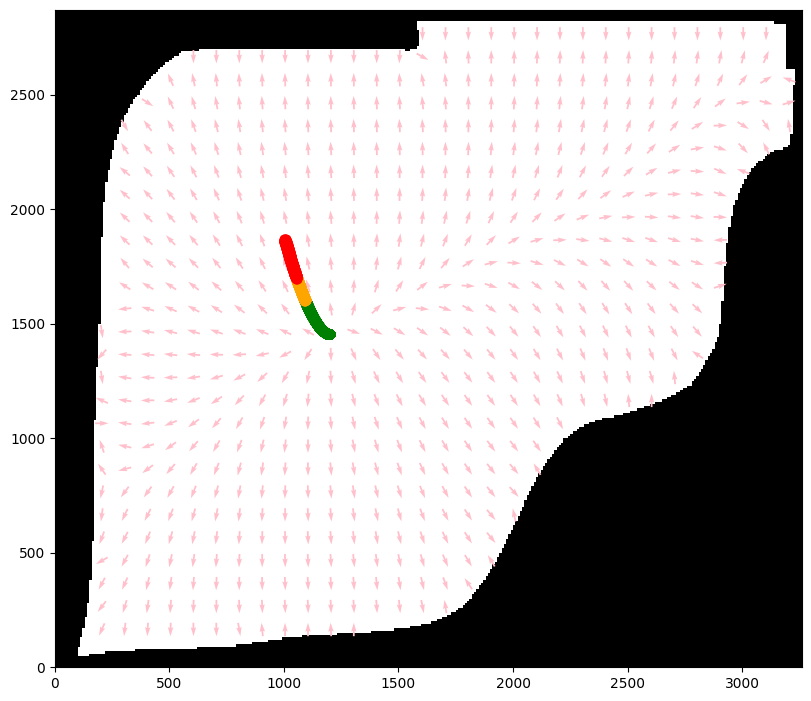

In [32]:
import matplotlib as mpl
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)
pmv = flopy.plot.PlotMapView(model = gwf, ax = ax, layer = 0)
# mm.plot_grid(ax = ax, color = ".5", alpha = 0.2) # 绘制网格
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
v = mm.plot_array(gwf.modelgrid.idomain, cmap=cmap, edgecolor="white")
mm.plot_pathline(p0, layer="all", color="blue", lw=0.75)
colors = ["green", "orange", "red"]
for k in range(nlay):
    mm.plot_timeseries(ts0, layer=k, marker="o", lw=0, color=colors[k]);

# 绘制等值线
plot_contour_array = mm.contour_array(concentration[9,0], masked_values = [1e30], cmap = "brg", linestyles="--")
plt.clabel(plot_contour_array, fmt = r'%.2f') # 绘制等值线上文本标注
# plt.colorbar(plot_contour_array)              # 等值线图例

mm.plot_bc(package = gwf.get_package("WEL-1"), color = 'green')
mm.plot_inactive(ibound = gwf.modelgrid.idomain, color_noflow = 'black')

# 绘制水流的方向 (粉红色箭头)
spdis = gwf.oc.output.budget().get_data(text = 'DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv.plot_vector(qx, qy, normalize = True, istep = 10, jstep = 10, color = "pink")

## Create and run the endpoint analysis model

In [33]:
from flopy.utils.gridgen import Gridgen

In [34]:
model_ws = sim_ws
gridgen_ws = os.path.join(model_ws, "gridgen")
g = Gridgen(dis6, model_ws=gridgen_ws, exe_name='/usr/local/lib/modflow/gridgen')

In [35]:
# pip install pyshp 
# pip install shapely 

In [36]:
# import pyshp

rf0shp = os.path.join(gridgen_ws, "rf0")
xmin = (100-3) * delr
xmax = (100+2) * delr
ymin = (100-2) * delc
ymax = (100+2) * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 1, range(nlay))

rf1shp = os.path.join(gridgen_ws, "rf1")
xmin = (100-2) * delr
xmax = (100+1) * delr
ymin = (100-1) * delc
ymax = (100+2) * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 2, range(nlay))

rf2shp = os.path.join(gridgen_ws, "rf2")
xmin = (100-1) * delr
xmax = 100 * delr
ymin = 100 * delc
ymax = (100+1) * delc
rfpoly = [
    [[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]
]
g.add_refinement_features(rfpoly, "polygon", 3, range(nlay))

In [37]:
ms = flopy.modflow.Modflow()
dis5 = flopy.modflow.ModflowDis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but w

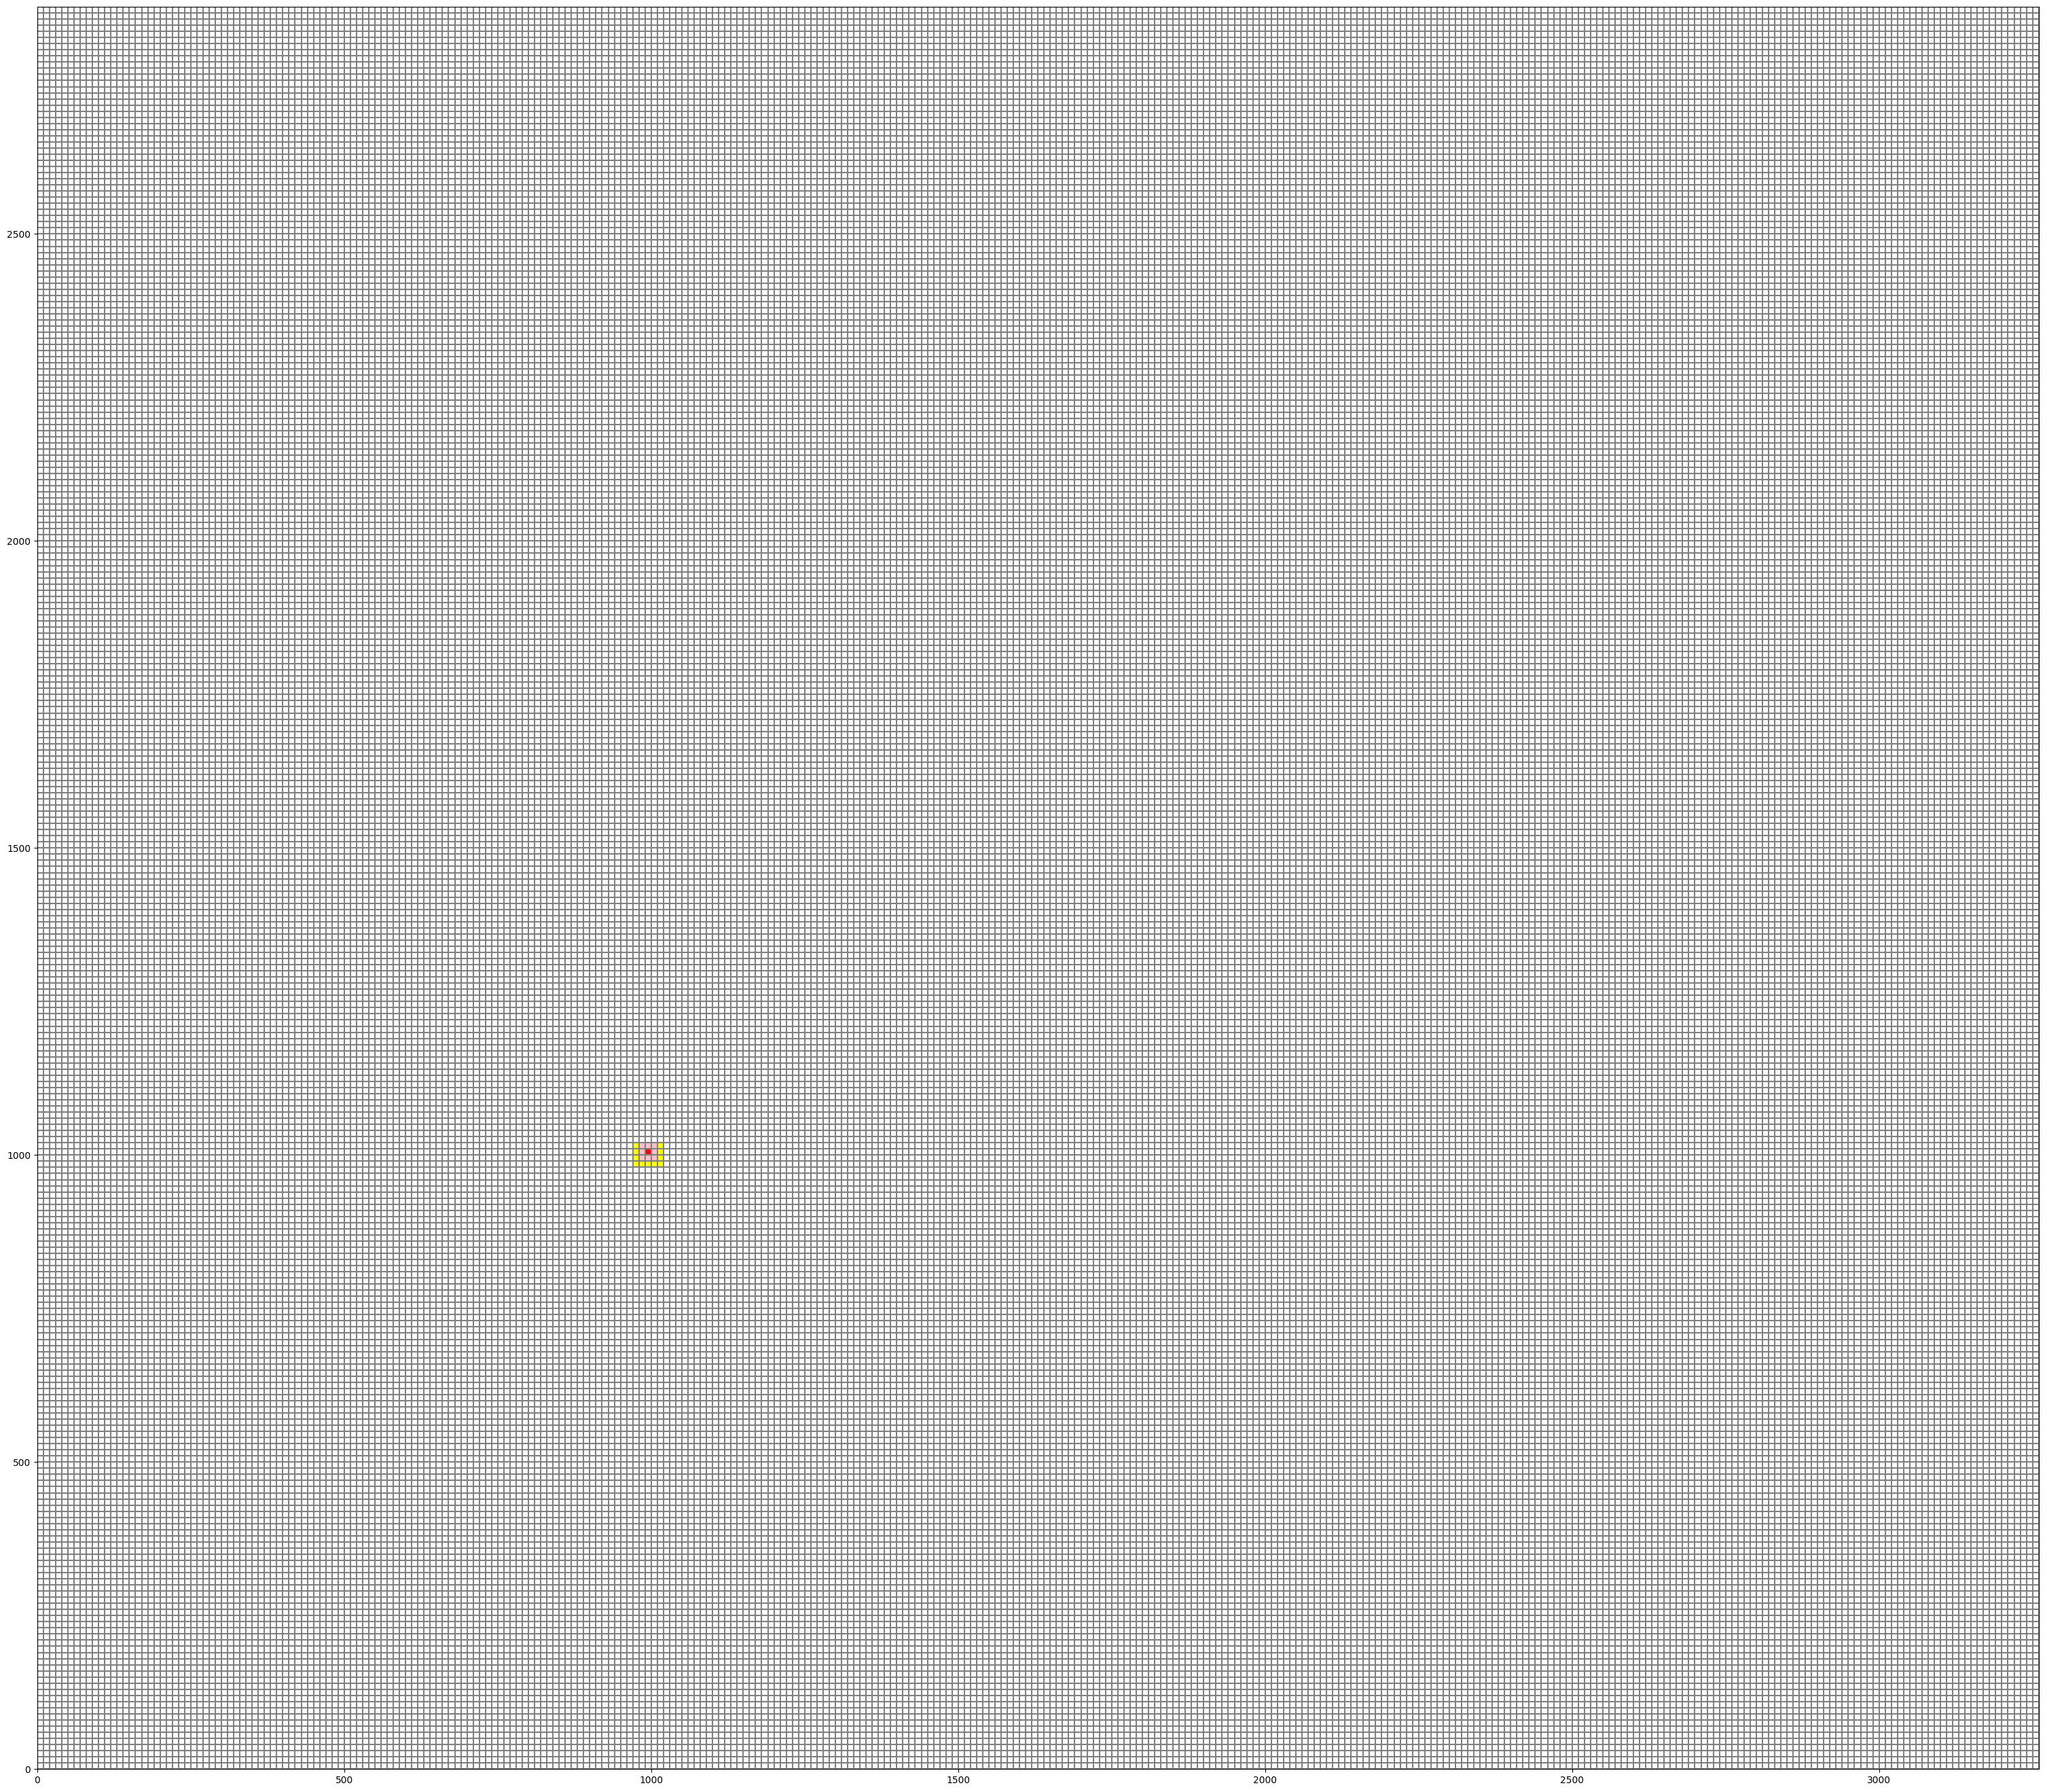

In [38]:
fig = plt.figure(figsize=(30, 30), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor="yellow", edgecolor="none")
flopy.plot.plot_shapefile(rf1shp, ax=ax, facecolor="pink", edgecolor="none")
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor="red", edgecolor="none");

In [39]:
g.build(verbose=False)

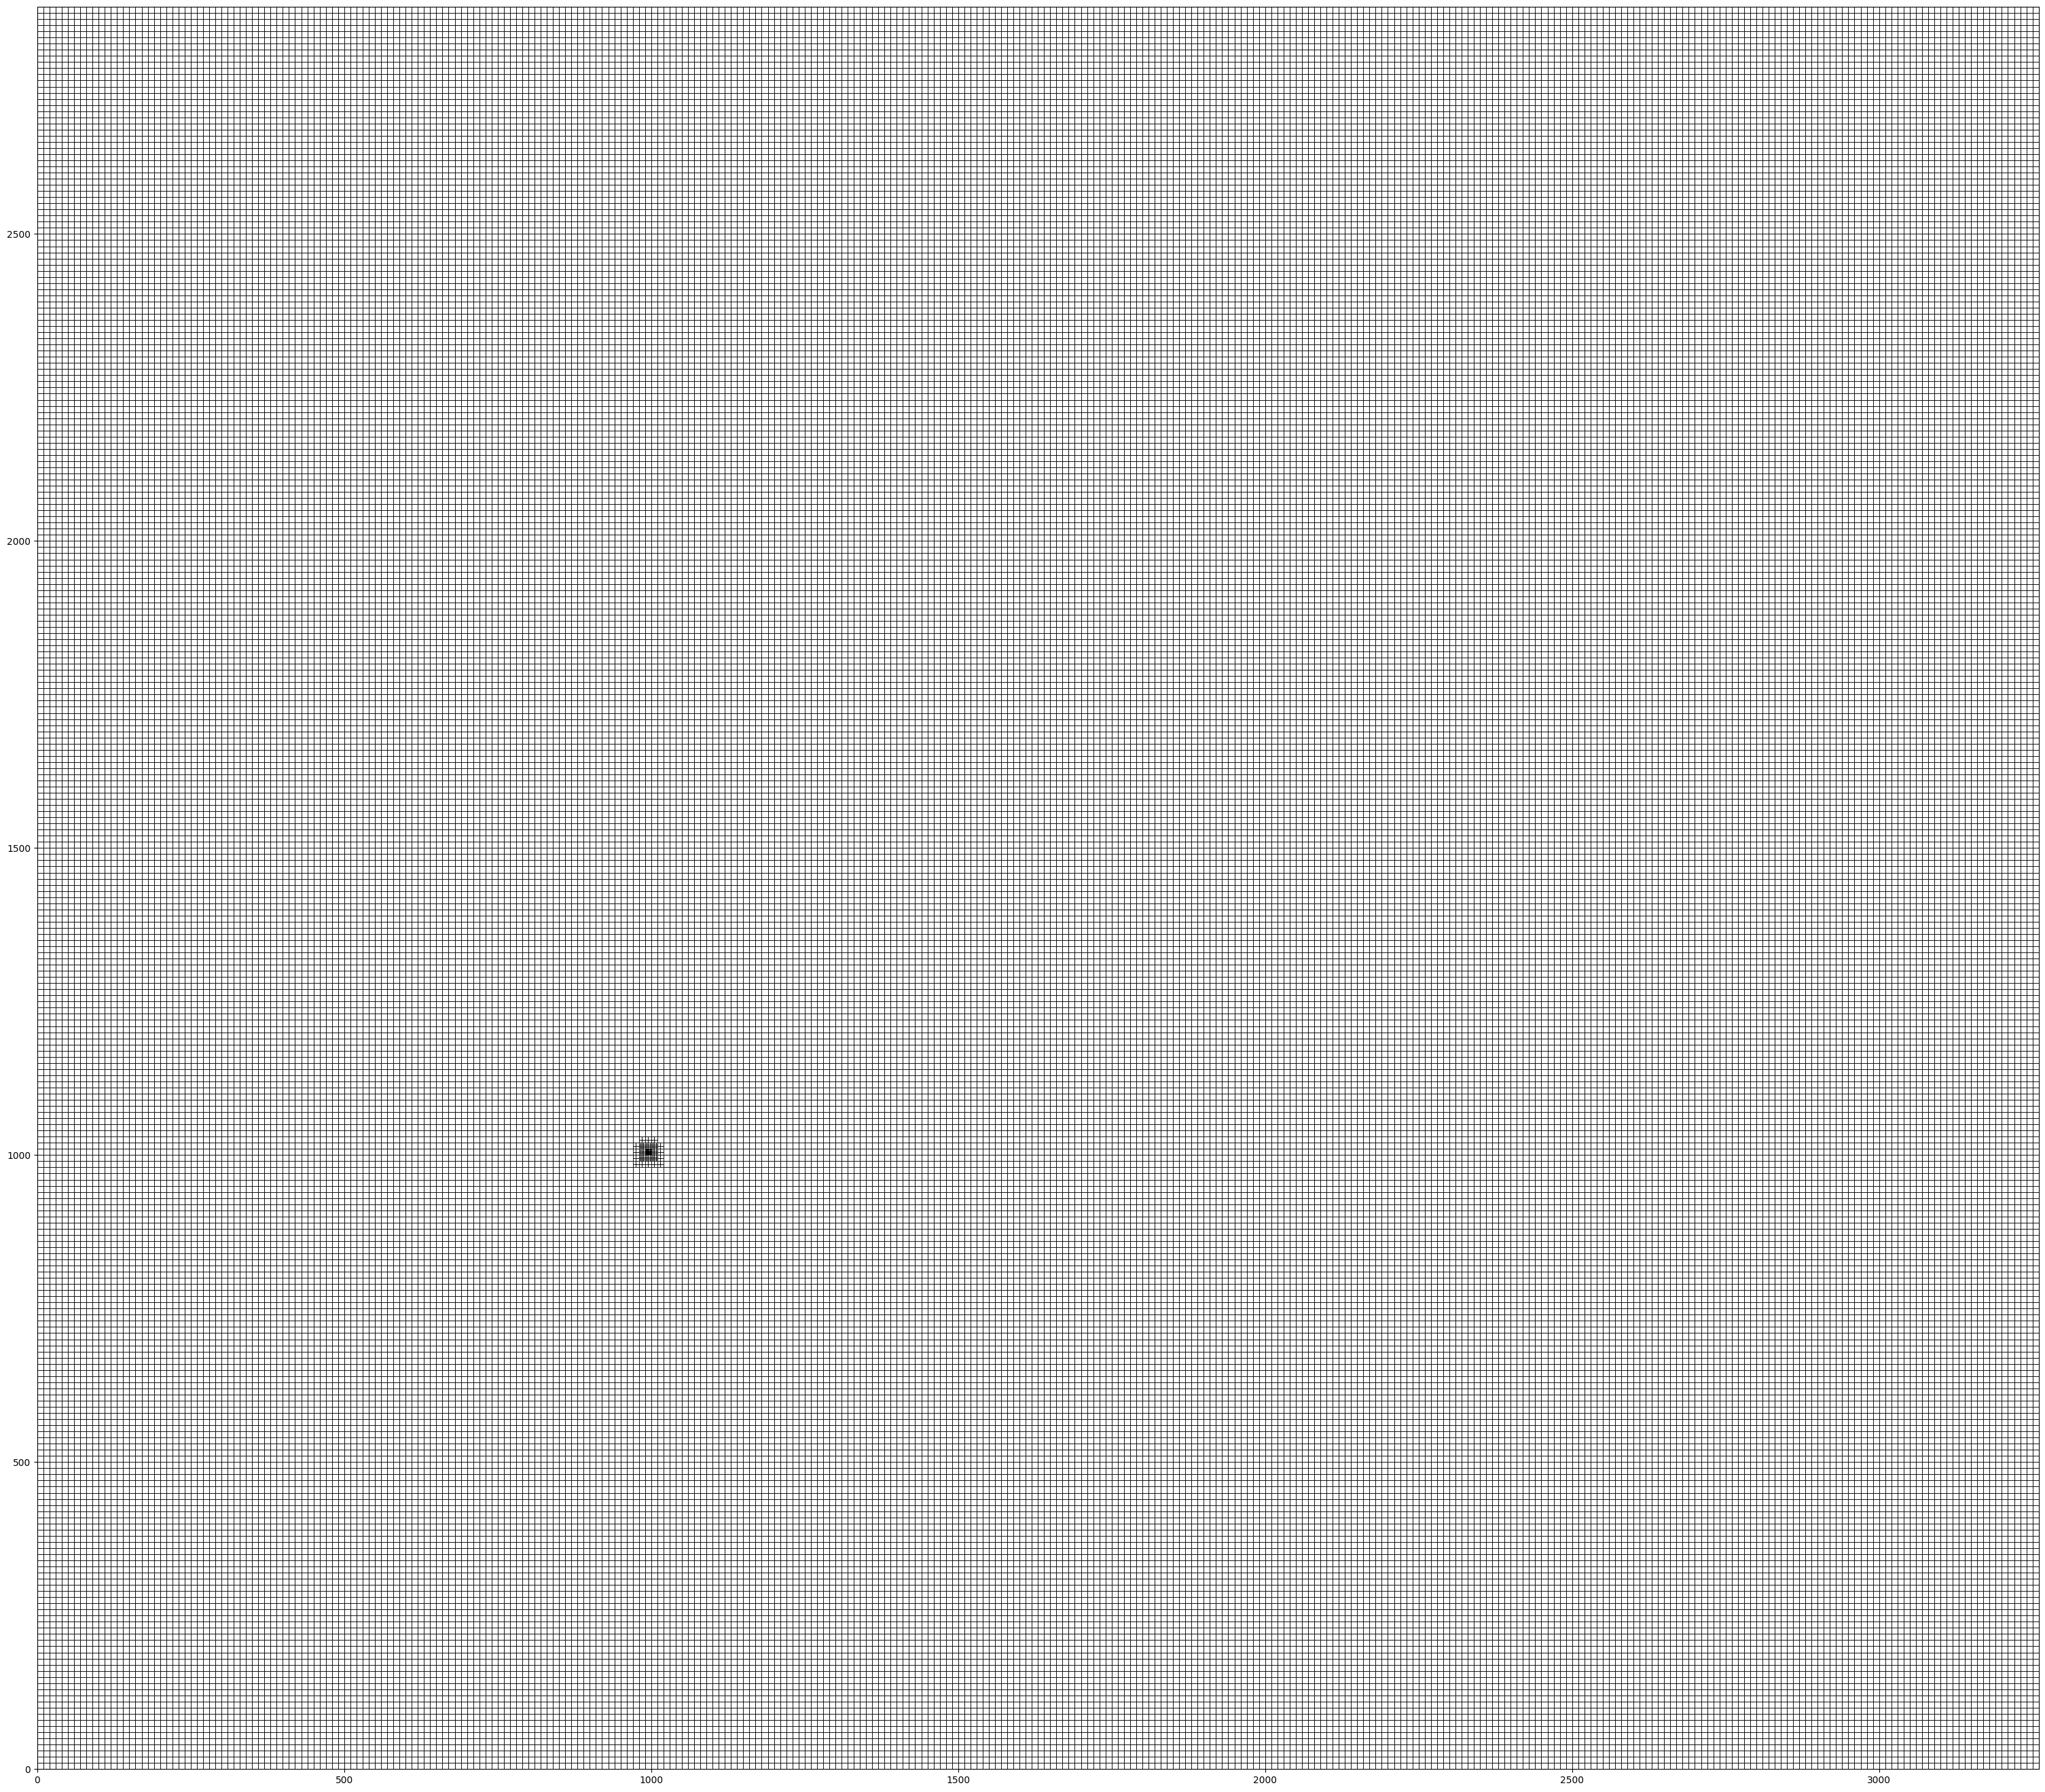

In [40]:
fig = plt.figure(figsize=(30, 30), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
g.plot(ax, linewidth=0.5);

In [41]:
gridprops = g.get_gridprops_disv()
# gridprops

In [42]:
ncpl = gridprops["ncpl"]
top = gridprops["top"]
botm = gridprops["botm"]
nvert = gridprops["nvert"]
vertices = gridprops["vertices"]
cell2d = gridprops["cell2d"]

In [43]:
ncpl

93787

In [44]:
# !pip install pyshp

In [45]:
# create simulation
model_name = sim_name
sim = flopy.mf6.MFSimulation(
    sim_name=model_name, version="mf6", exe_name="/usr/local/lib/modflow/mf6", sim_ws=sim_ws
)

# create tdis package
tdis_rc = [(1000.0, 1, 1.0)]
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc
)

# create gwf model
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=model_name, model_nam_file="{}.nam".format(model_name)
)
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    print_option="SUMMARY",
    complexity="SIMPLE",
    outer_dvclose=1.0e-5,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=1.0e-6,
    rcloserecord=0.1,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)
sim.register_ims_package(ims, [gwf.name])

# disv
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl,
    top=top,
    botm=botm,
    nvert=nvert,
    vertices=vertices,
    cell2d=cell2d,
    # idomain=idomain,
)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=320.0)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=[("xt3d")],
    icelltype=[1, 0, 0],
    k=[50.0, 0.01, 200.0],
    k33=[10.0, 0.01, 20.0],
)

# wel
wellpoints = [(1000.0, 1000.0)]
welcells = g.intersect(wellpoints, "point", 0)
# welspd = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, maxbound=1, aux_vars=['iface'])
welspd = [[(2, icpl), -150000, 0] for icpl in welcells["nodenumber"]]
wel = flopy.mf6.ModflowGwfwel(
    gwf, print_input=True, auxiliary=[("iface",)], stress_period_data=welspd
)

# rch
aux = [np.ones(ncpl, dtype=int) * 6]
rch = flopy.mf6.ModflowGwfrcha(
    gwf, recharge=0.005, auxiliary=[("iface",)], aux={0: [6]}
)
# riv
riverline = [[[(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]]]
rivcells = g.intersect(riverline, "line", 0)
rivspd = [[(0, icpl), 320.0, 100000.0, 318] for icpl in rivcells["nodenumber"]]
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)

# output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord="{}.cbb".format(model_name),
    head_filerecord="{}.hds".format(model_name),
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model model...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 287 based on size of stress_period_data
    writing package oc...


In [46]:
sim.run_simulation()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 03/08/2022
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Mar 08 2022 20:13:10 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USG

(True, [])

In [47]:
fname = os.path.join(model_ws, model_name + ".disv.grb")
grd = flopy.mf6.utils.MfGrdFile(fname, verbose=False)
mg = grd.modelgrid

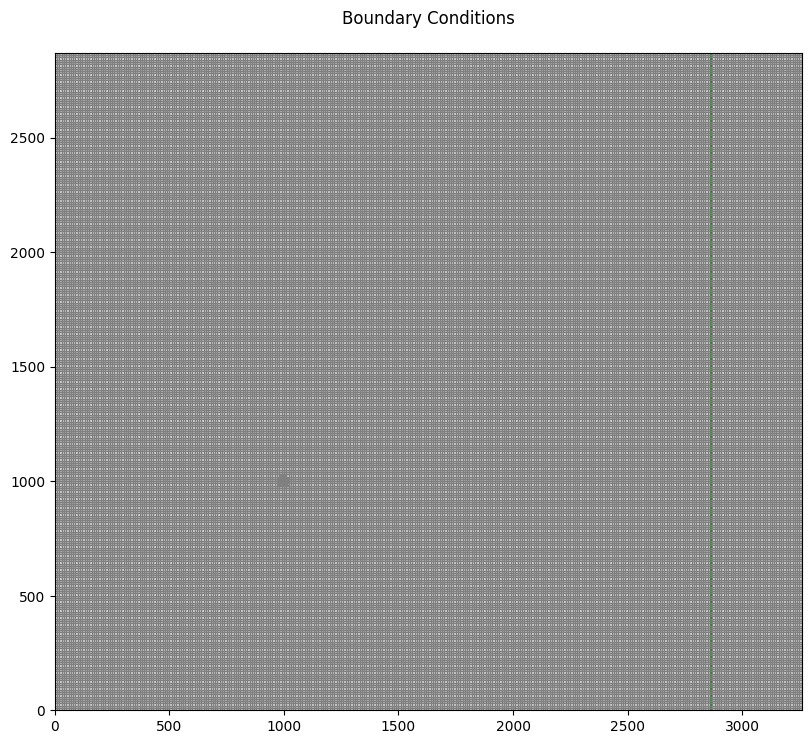

In [48]:
ibd = np.zeros((ncpl), dtype=int)
ibd[welcells["nodenumber"]] = 1
ibd[rivcells["nodenumber"]] = 2
ibd = np.ma.masked_equal(ibd, 0)
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
pc = pmv.plot_array(ibd, cmap=cmap, edgecolor="gray")
t = ax.set_title("Boundary Conditions\n");

In [49]:
fname = os.path.join(model_ws, model_name + ".hds")
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
head.shape

(3, 1, 93787)

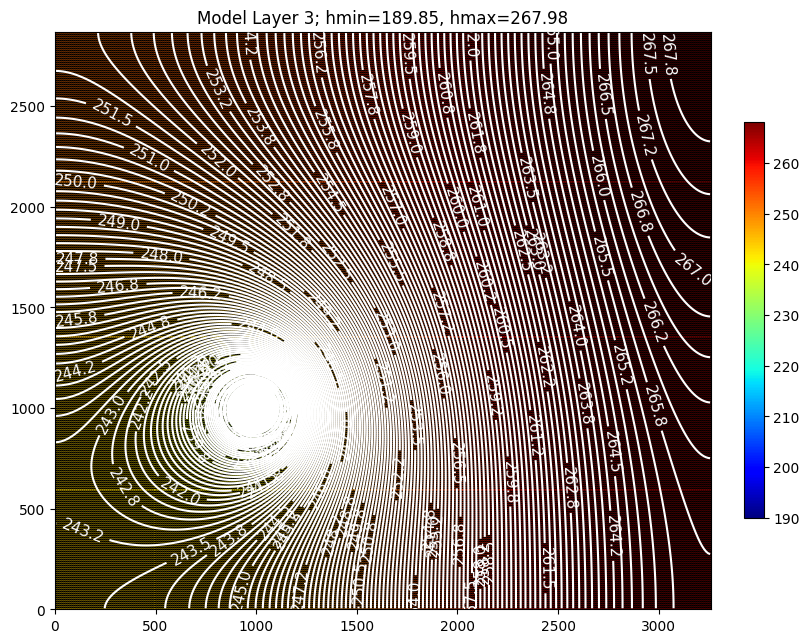

In [50]:
ilay = 2
cint = 0.25
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax, layer=ilay)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
pc = mm.plot_array(head[:, 0, :], cmap="jet", edgecolor="black")
hmin = head[ilay, 0, :].min()
hmax = head[ilay, 0, :].max()
levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
cs = mm.contour_array(head[:, 0, :], colors="white", levels=levels)
plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)
cb = plt.colorbar(pc, shrink=0.5)
t = ax.set_title(
    "Model Layer {}; hmin={:6.2f}, hmax={:6.2f}".format(ilay + 1, hmin, hmax)
);

In [51]:
# Create particles for endpoint analysis
facedata = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=10,
    horizontaldivisions1=10,
    verticaldivisions2=10,
    horizontaldivisions2=10,
    verticaldivisions3=10,
    horizontaldivisions3=10,
    verticaldivisions4=10,
    horizontaldivisions4=10,
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=4,
    columndivisions6=4,
)
pb = flopy.modpath.NodeParticleData(subdivisiondata=facedata, nodes=nodew)
# create forward particle group
fpth = mp_nameb + ".sloc"
pgb = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname="BACKWARD2", particledata=pb, filename=fpth
)

In [52]:
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=mp_nameb, flowmodel=gwf, exe_name="/usr/local/lib/modflow/mp7", model_ws=sim_ws
)
flopy.modpath.Modpath7Bas(mp, porosity=porosity)
flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="endpoint",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    particlegroups=pgb,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mp7

MODPATH Version 7.2.001   
Program compiled Mar 08 2022 20:16:00 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
      1248 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

In [53]:
fpth = os.path.join(model_ws, mp_nameb + ".mpend")
e = flopy.utils.EndpointFile(fpth)
e0 = e.get_alldata()

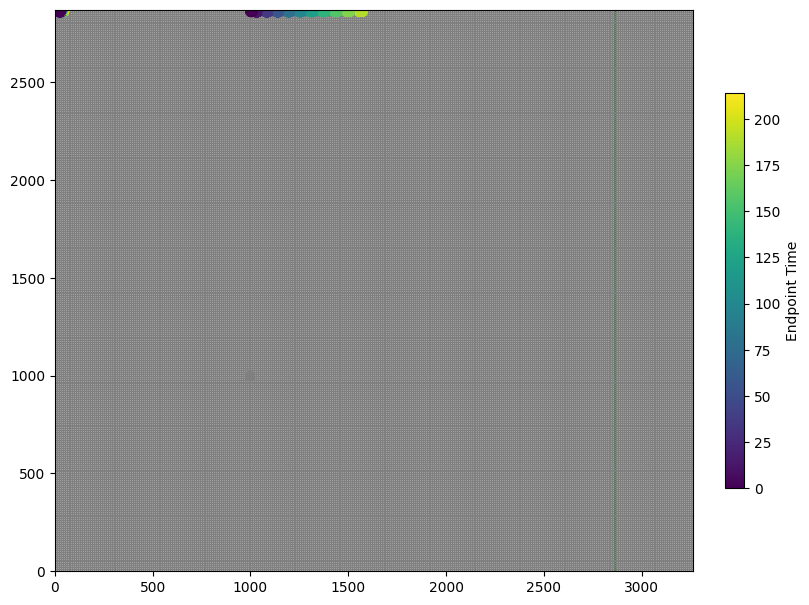

In [54]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
v = mm.plot_array(ibd, cmap=cmap, edgecolor="gray")
mm.plot_endpoint(e0, direction="ending", colorbar=True, shrink=0.5);

### 轨迹

In [55]:
pcoord = np.array(
    [
        [0.000, 0.125, 0.500],
        [0.000, 0.375, 0.500],
        [0.000, 0.625, 0.500],
        [0.000, 0.875, 0.500],
        [1.000, 0.125, 0.500],
        [1.000, 0.375, 0.500],
        [1.000, 0.625, 0.500],
        [1.000, 0.875, 0.500],
        [0.125, 0.000, 0.500],
        [0.375, 0.000, 0.500],
        [0.625, 0.000, 0.500],
        [0.875, 0.000, 0.500],
        [0.125, 1.000, 0.500],
        [0.375, 1.000, 0.500],
        [0.625, 1.000, 0.500],
        [0.875, 1.000, 0.500],
    ]
)
nodew = gwf.disv.ncpl.array * 2 + welcells["nodenumber"][0]
plocs = [nodew for i in range(pcoord.shape[0])]

# create particle data
pa = flopy.modpath.ParticleData(
    plocs,
    structured=False,
    localx=pcoord[:, 0],
    localy=pcoord[:, 1],
    localz=pcoord[:, 2],
    drape=0,
)

# create backward particle group
fpth = mp_namea + ".sloc"
pga = flopy.modpath.ParticleGroup(
    particlegroupname="BACKWARD1", particledata=pa, filename=fpth
)

In [56]:
facedata = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=10,
    horizontaldivisions1=10,
    verticaldivisions2=10,
    horizontaldivisions2=10,
    verticaldivisions3=10,
    horizontaldivisions3=10,
    verticaldivisions4=10,
    horizontaldivisions4=10,
    rowdivisions5=0,
    columndivisions5=0,
    rowdivisions6=4,
    columndivisions6=4,
)
pb = flopy.modpath.NodeParticleData(subdivisiondata=facedata, nodes=nodew)
# create forward particle group
fpth = mp_nameb + ".sloc"
pgb = flopy.modpath.ParticleGroupNodeTemplate(
    particlegroupname="BACKWARD2", particledata=pb, filename=fpth
)

In [57]:
# create modpath files
mp = flopy.modpath.Modpath7(
    modelname=mp_namea, flowmodel=gwf, exe_name="/usr/local/lib/modflow/mp7", model_ws=model_ws
)
flopy.modpath.Modpath7Bas(mp, porosity=0.1)
flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    referencetime=0.0,
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    particlegroups=pga,
)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following executable to run the model: /usr/local/lib/modflow/mp7

MODPATH Version 7.2.001   
Program compiled Mar 08 2022 20:16:00 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
        16 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

In [58]:
fpth = os.path.join(model_ws, mp_namea + ".mppth")
p = flopy.utils.PathlineFile(fpth)
p0 = p.get_alldata()
fpth = os.path.join(model_ws, mp_namea + ".timeseries")
ts = flopy.utils.TimeseriesFile(fpth)
ts0 = ts.get_alldata()

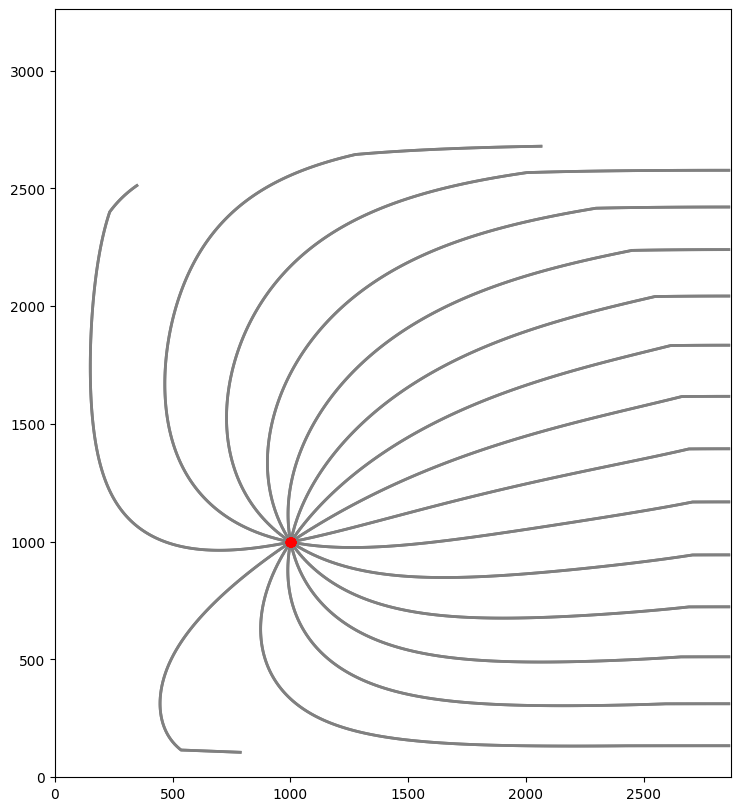

In [61]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(modelgrid=mg, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
cmap = mpl.colors.ListedColormap(
    [
        "r",
        "g",
    ]
)
# v = mm.plot_array(ibd, cmap=cmap, edgecolor="gray")
mm.plot_pathline(p0, layer="all", color="blue", lw=2)
colors = ["green", "orange", "red"]
for k in range(nlay):
    mm.plot_timeseries(ts0, layer=k, marker="o", lw=0, color=colors[k]);